In [1]:
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd

from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata

In [2]:
dciopse=xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/ciopse_mask_trex_250m.nc')
draster=xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/mask_trex_250m_from_raster.nc')

In [3]:
dciopse = dciopse.swap_dims({'X': 'lon', 'Y': 'lat'}).transpose('lat', 'lon')
dciopse

<xarray.Dataset> Size: 14MB
Dimensions:  (lon: 4500, lat: 3116)
Coordinates:
  * lon      (lon) float32 18kB -69.0 -69.0 -68.99 ... -53.74 -53.74 -53.73
  * lat      (lat) float32 12kB 45.0 45.0 45.0 45.01 ... 52.0 52.0 52.0 52.0
Data variables:
    mask     (lat, lon) uint8 14MB ...

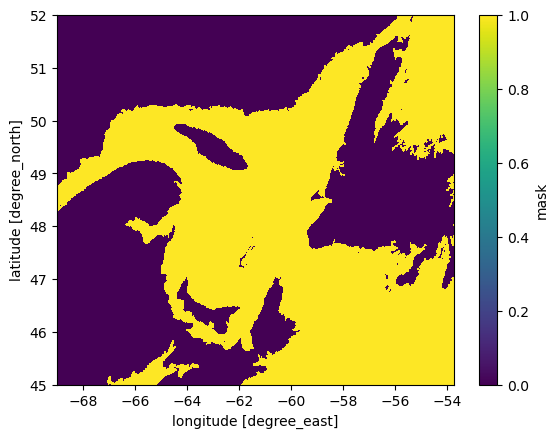

In [4]:
dciopse.mask.plot()

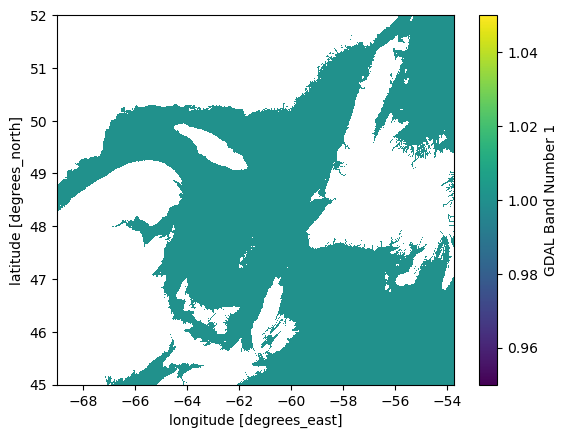

In [5]:
draster.Band1.plot()

In [6]:
mask1 = dciopse.mask.data # mask 1 is from ciopse
mask2 = np.nan_to_num(draster.Band1.data) # mask 2 is from raster

In [7]:
diff = mask1 - mask2
mask3 = (diff != 0)*1 # mask 3 is where mask1 and mask2 aren't equal

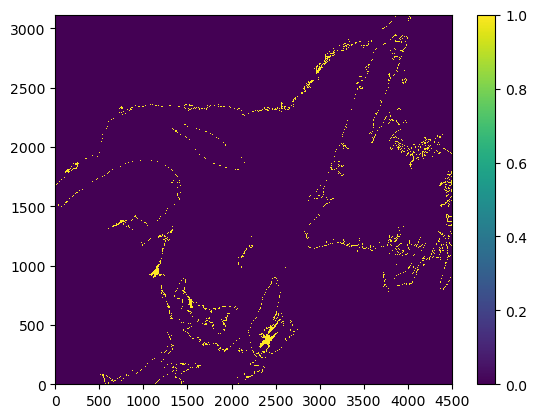

In [8]:
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(mask3)
plt.colorbar(mesh)

## Load the water.gpkg

In [9]:
water = gpd.read_file('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/water.gpkg')
water

geometry
0  MULTIPOLYGON (((-67.53263 44.64044, -67.53243 ...

<Axes: >

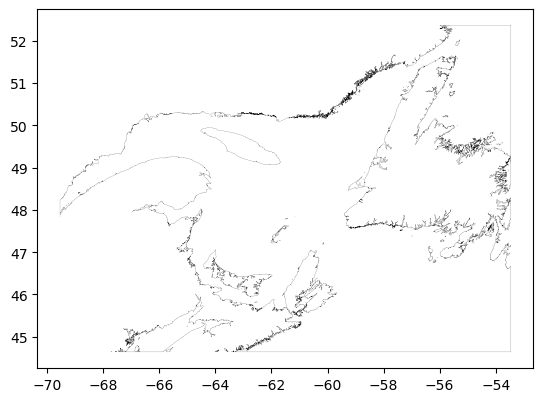

In [10]:
water.boundary.plot(color='k', lw=0.1)

# Defning red with CIOPSE mask

Number of redzone points:  7306490


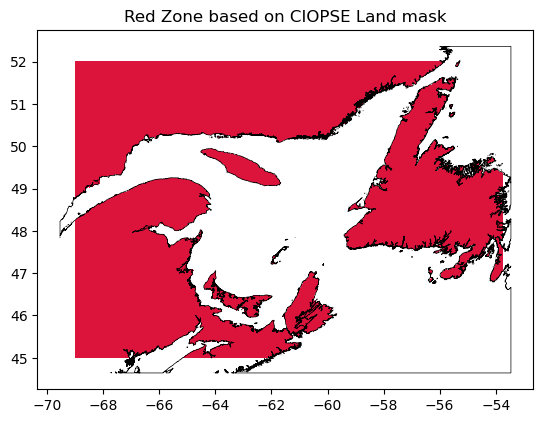

In [11]:
cmap_red = ListedColormap([ "white", "crimson"])
redzone1 = 1-mask1
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, redzone1, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone based on CIOPSE Land mask')
print("Number of redzone points: ", np.sum(redzone1))

Number of redzone points:  212561


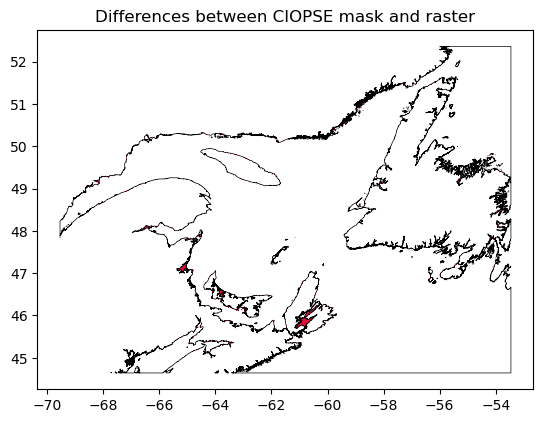

In [12]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, mask3, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Differences between CIOPSE mask and raster')
print("Number of redzone points: ", np.sum(mask3))

Number of redzone points:  7370571


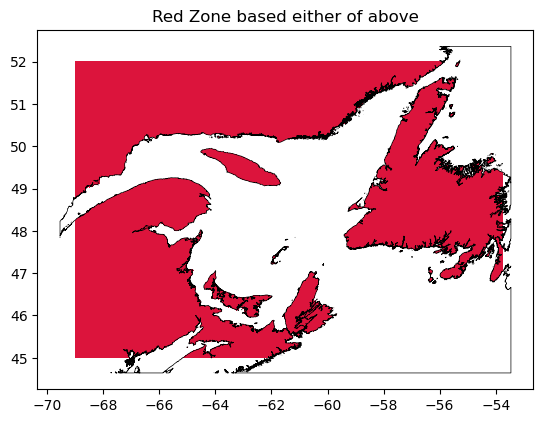

In [13]:
redzone2 = redzone1 | mask3
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, redzone2, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone based either of above')
print("Number of redzone points: ", np.sum(redzone2))

Number of additional redzone points:  64081


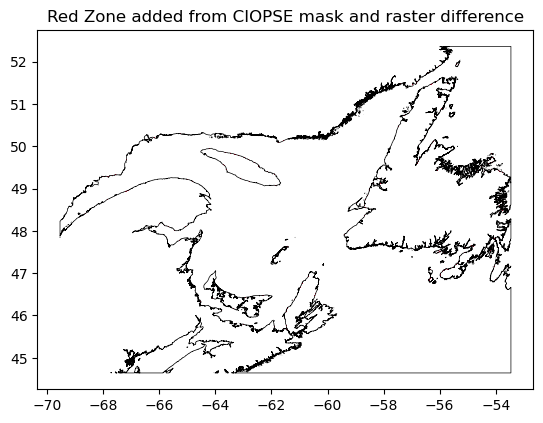

In [14]:
additional_points = ~redzone1 & mask3
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, additional_points, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone added from CIOPSE mask and raster difference')
print("Number of additional redzone points: ", np.sum(additional_points))

## Zooming in on POC area

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


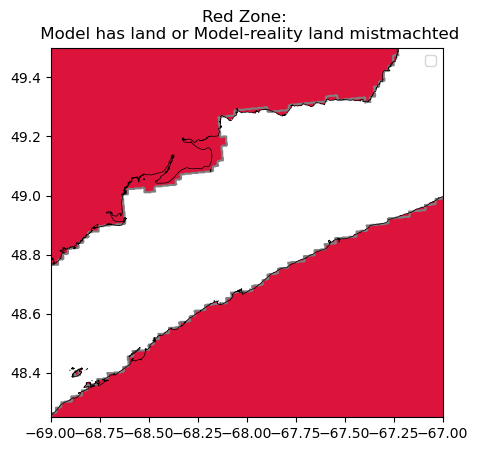

In [15]:
lon_min=-69
lon_max=-67
lat_min=48.25
lat_max=49.5

redzone2 = redzone1 | mask3
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dciopse.lon, dciopse.lat, redzone2, cmap=cmap_red)
ax.contour(dciopse.lon, dciopse.lat, dciopse.mask, levels=[0], colors='grey')
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone: \n Model has land or Model-reality land mistmachted')
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.legend()

In [16]:
fig.savefig('redzone_landmask_or_mistmatch.png', bbox_inches='tight', dpi=300)

# Moving onto bathymetry comparisons

In [17]:
dciopse['redzone_landmask'] = xr.DataArray(redzone2, dims=('lat', 'lon'))
dcsub = dciopse.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

In [18]:
gebco = xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/GEBCO_08_Mar_2024_32af4330d8c2/gebco_2023_n49.5_s48.25_w-69.0_e-67.0.nc')

gebco_interp = gebco.interp(lon=dcsub.lon, lat=dcsub.lat)

gebco = gebco.where(gebco['elevation']<=0)
gebco['depth'] = -gebco['elevation']
gebco['depth'].attrs = {'long_name': 'Depth relative to sea level',
                        'units': 'm'}

gebco_interp= gebco_interp.where(gebco_interp['elevation']<=0)
gebco_interp['depth'] = -gebco_interp['elevation']
gebco_interp['depth'].attrs = {'long_name': 'Depth relative to sea level',
                              'units': 'm'}

In [19]:
gebco

<xarray.Dataset> Size: 1MB
Dimensions:    (lat: 300, lon: 480)
Coordinates:
  * lat        (lat) float64 2kB 48.25 48.26 48.26 48.26 ... 49.49 49.49 49.5
  * lon        (lon) float64 4kB -69.0 -68.99 -68.99 ... -67.01 -67.01 -67.0
Data variables:
    elevation  (lat, lon) float32 576kB nan nan nan nan ... -196.0 -200.0 -202.0
    depth      (lat, lon) float32 576kB nan nan nan nan ... 196.0 200.0 202.0
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0

In [20]:
gebco_interp

<xarray.Dataset> Size: 5MB
Dimensions:    (lat: 556, lon: 590)
Coordinates:
  * lon        (lon) float32 2kB -69.0 -69.0 -68.99 ... -67.01 -67.0 -67.0
  * lat        (lat) float32 2kB 48.25 48.25 48.26 48.26 ... 49.49 49.5 49.5
Data variables:
    elevation  (lat, lon) float64 3MB nan nan nan nan nan ... nan nan nan nan
    depth      (lat, lon) float64 3MB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0

(-69.0, -67.0)

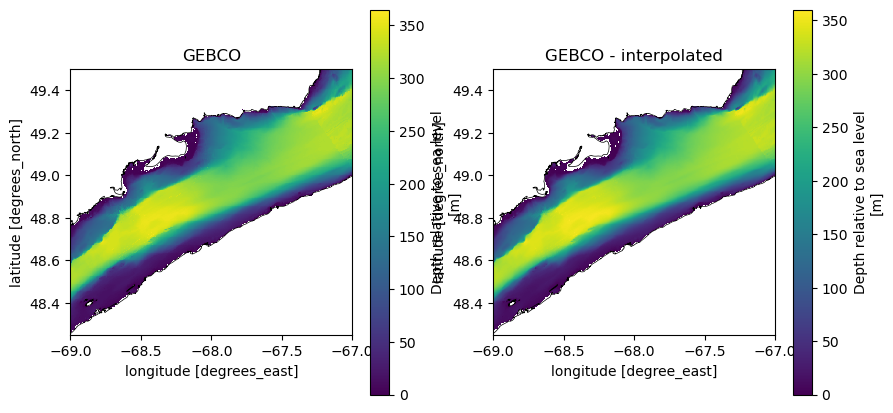

In [21]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
gebco.depth.plot(ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('GEBCO')
ax=axs[1]
gebco_interp.depth.plot(ax=ax)
ax.set_title('GEBCO - interpolated')
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [22]:
fig.savefig('gebco_bathy.png', bbox_inches='tight',dpi=200)

# CIOPSE bathymetry

In [23]:
bathy_c = xr.open_dataset('/home/soontiensn/data/gpsc-sdfo000/opp_drift_fa3/share_drift/CIOPSE_SN1500/CIOPSE_mesh_files/NWA36_Bathymetry_flatbdy_20181109_3_fillchannels_filter_min_7p5.nc')
mesh = xr.open_dataset('/home/soontiensn/data/gpsc-sdfo000/opp_drift_fa3/share_drift/CIOPSE_SN1500/CIOPSE_mesh_files/mesh_mask_NWA36_Bathymetry_flatbdy_20181109_3_filter_min_7p5.nc')
nav_lon = mesh.nav_lon
nav_lat = mesh.nav_lat

(-69.0, -67.0)

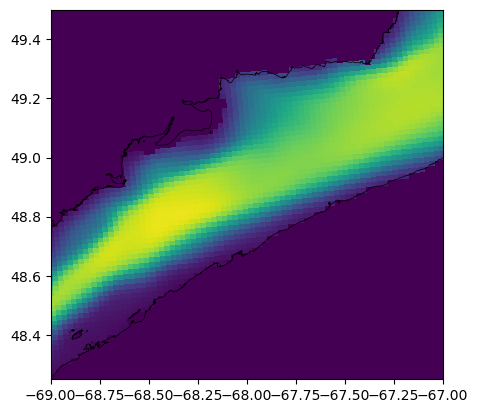

In [24]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(nav_lon, nav_lat, bathy_c.Bathymetry,vmin=gebco.depth.min(), vmax=gebco.depth.max())
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [25]:
# interpolating ciopse to the same grid
long, latg = np.meshgrid(dcsub.lon.values, dcsub.lat.values)
ciopse_interp = griddata((nav_lon.values.flatten(), nav_lat.values.flatten()), 
                         bathy_c.Bathymetry.values.flatten(), 
                         (long, latg))

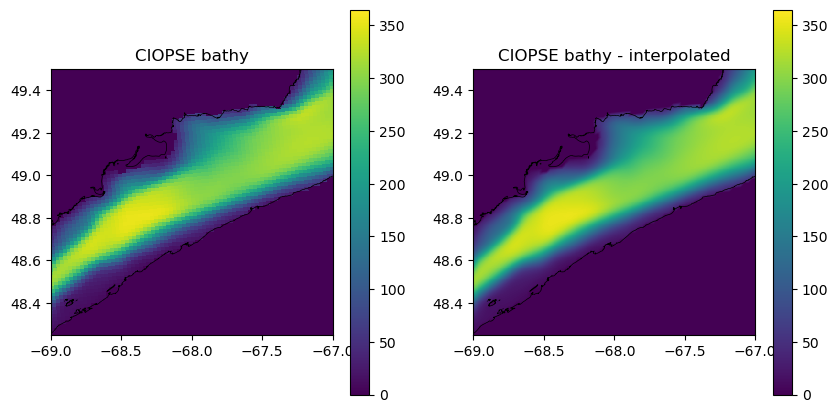

In [26]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh = ax.pcolormesh(nav_lon, nav_lat, bathy_c.Bathymetry,vmin=gebco.depth.min(), vmax=gebco.depth.max())
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('CIOPSE bathy')
plt.colorbar(mesh)
ax=axs[1]
mesh = ax.pcolormesh(long, latg, ciopse_interp,vmin=gebco.depth.min(), vmax=gebco.depth.max())
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('CIOPSE bathy - interpolated')
plt.colorbar(mesh)

In [27]:
fig.savefig('ciopse_bathy.png', bbox_inches='tight',dpi=200)

In [28]:
dcsub['ciopse_bathy_interp'] = xr.DataArray(ciopse_interp, dims=('lat', 'lon'))

In [29]:
dcsub_ciopse = dcsub.where(dcsub['ciopse_bathy_interp']>0)

In [30]:
diff = ciopse_interp- gebco_interp.depth 

In [31]:
reldiff = np.abs(diff)/(dcsub['ciopse_bathy_interp'])
thres=0.1

Text(0.5, 1.0, 'abs(ciose-gebco)/(ciopse)')

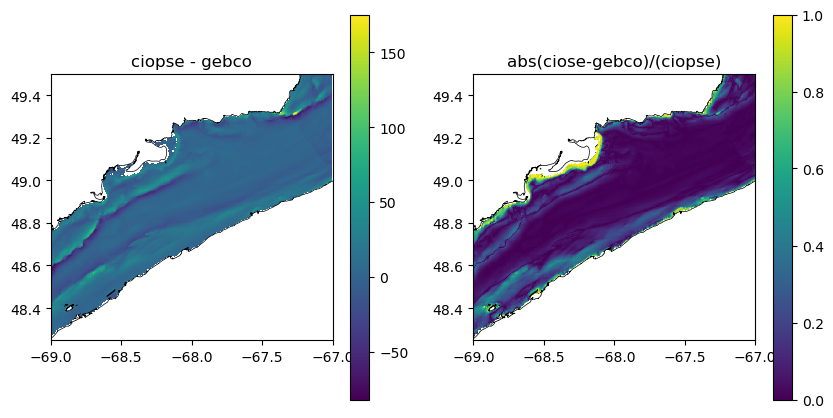

In [32]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh = ax.pcolormesh(long, latg, diff)
plt.colorbar(mesh,ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('ciopse - gebco')
ax=axs[1]
mesh = ax.pcolormesh(long, latg, reldiff,vmin=0,vmax=1)
plt.colorbar(mesh,ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])
ax.set_title('abs(ciose-gebco)/(ciopse)')

In [33]:
fig.savefig('bathy_differences.png', bbox_inches='tight',dpi=200)

In [34]:
mask = reldiff>thres

(-69.0, -67.0)

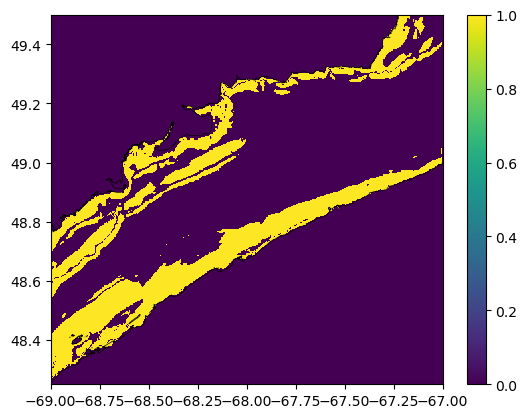

In [35]:
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(long, latg, mask)
plt.colorbar(mesh,ax=ax)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [36]:
dcsub['redzone_bathy'] = xr.DataArray(mask, dims=('lat', 'lon'))

(-69.0, -67.0)

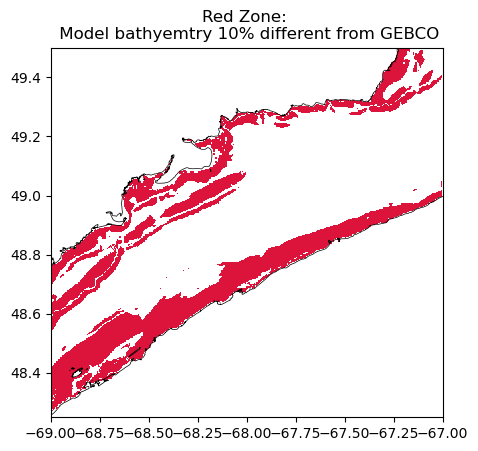

In [37]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(dcsub.lon, dcsub.lat, dcsub.redzone_bathy, cmap=cmap_red)
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone: \n Model bathyemtry 10% different from GEBCO')
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [38]:
redzoneall = dcsub['redzone_bathy'] | dcsub['redzone_landmask']
dcsub['redzone_all'] = xr.DataArray(redzoneall, dims=('lat', 'lon'))

(-69.0, -67.0)

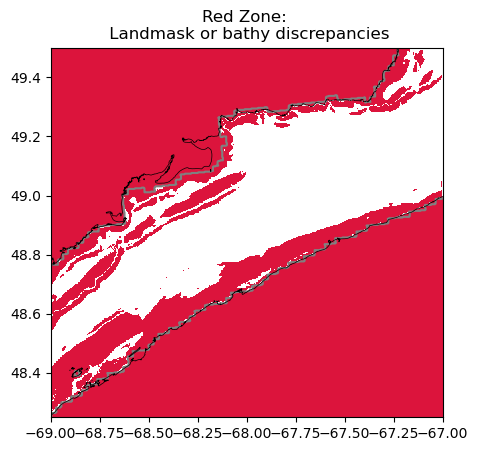

In [39]:

fig, ax = plt.subplots(1,1)
ax.pcolormesh(dcsub.lon, dcsub.lat, dcsub.redzone_all, cmap=cmap_red)
ax.contour(dciopse.lon, dciopse.lat, dciopse.mask, levels=[0], colors='grey')
water.boundary.plot(color='k', lw=0.5, ax=ax)
ax.set_title('Red Zone: \n Landmask or bathy discrepancies')
ax.set_ylim([lat_min,lat_max])
ax.set_xlim([lon_min,lon_max])

In [40]:
fig.savefig('redzone_landmask_or_mistmatch_or_relbathydifference0.1.png', bbox_inches='tight', dpi=300)